In [1]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)

# Write a function for the integrand, i.e. 1/E(z)1/E(z)1/E(z),
def ezinv(z,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    ol = 1.0 - om
    ez = np.sqrt(om*(1+z)**3  + ol)
    return 1./ez

# The curvature correction function
def Sk(xx, ok):
    if ok < 0.0:
        dk = np.sin(np.sqrt(-ok)*xx)/np.sqrt(-ok)
    elif ok > 0.0:
        dk = np.sinh(np.sqrt(ok)*xx)/np.sqrt(ok)
    else:
        dk = xx
    return dk

# The distance modulus
def dist_mod(zs,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 0
    xx = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in zs])
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod

1829


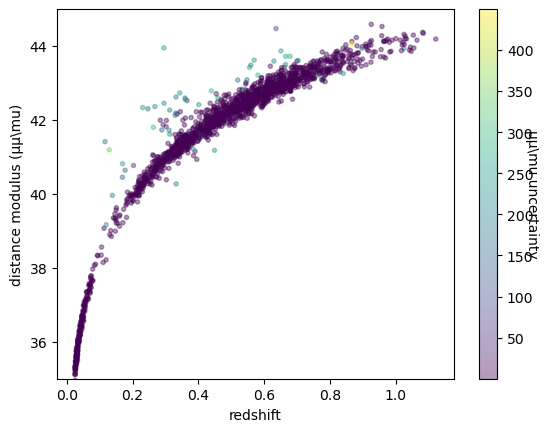

In [2]:
# Add a new function that reads in the data (data files should be in a directory called data)
import pandas as pd  # Pandas is a useful package to read in data files and select portions of the data

df = pd.read_csv('/Users/april/Downloads/DES-SN5YR_HD.csv') # Pandas reads into a "data frame (we'll call it df)"
zHELs = df['zHEL'].to_numpy() # You can keep using it in Pandas format, but just turning it into numpy arrays so it matches what you did above. 
zHDs = df['zHD'].to_numpy()
mu = df['MU'].to_numpy()
muerr = df['MUERR_FINAL'].to_numpy()
nSN = len(zHDs)
print(nSN)

hubblediagram=plt.scatter(zHDs,mu,marker='.',c=muerr,alpha=0.4)
plt.xlabel('redshift')
plt.ylabel('distance modulus (μμ\mu)')
cbar=plt.colorbar(hubblediagram)
cbar.set_label('μμ\mu uncertainty', rotation=270)
plt.ylim(35,45)
plt.show()

# Warning, with this many data points it's going to take a long time to do the fit!  Test with a small grid first!  
# And consider adding interpolation to determine luminosity distances instead of doing this many integrals.


In [5]:
# finding best fit using array
# tried to get chi squared near 1
# Set up the arrays for the models you want to test, e.g. a range of Omega_m and Omega_Lambda models:
n = 100                          # Increase this for a finer grid
oms = np.linspace(0.0, 0.5, n)   # Array of matter densities
#ols = np.linspace(0.0, 1.0, n)   # Array of cosmological constant values
#ols = [-i + 1 for i in oms]
chi2 = np.ones((n, n)) * np.inf  # Array to hold our chi2 values, set initially to super large values

# Calculate Chi2 for each model
for i, om in enumerate(oms):                                          # loop through matter densities
       # for j, ol in enumerate(ols):                                  # loop through cosmological constant densities
    ols = [-i + 1 for i in oms]
    mu_model = dist_mod(zHDs, om=oms[i], ol=ols[i])                     # calculate the distance modulus vs redshift for that model 
    mscr = np.sum((mu_model-mu)/muerr**2)/np.sum(1./muerr**2) # Calculate the vertical offset to apply
    mu_model_norm = mu_model-mscr                             # Apply the vertical offset
    chi2[i,i] = np.sum((mu_model_norm - mu) ** 2 / muerr**2)  # Calculate the chi2 and save it in a matrix
            
# Convert that to a likelihood and calculate the reduced chi2
likelihood = np.exp(-0.5 * (chi2-np.amin(chi2)))  # convert the chi^2 to a likelihood (np.amin(chi2) calculates the minimum of the chi^2 array)
chi2_reduced = chi2 / (len(mu)-2)                 # calculate the reduced chi^2, i.e. chi^2 per degree of freedom, where dof = number of data points minus number of parameters being fitted 

# Calculate the best fit values (where chi2 is minimum)
indbest = np.argmin(chi2)                 # Gives index of best fit but where the indices are just a single number
ibest   = np.unravel_index(indbest,[n,n]) # Converts the best fit index to the 2d version (i,j)
print( 'Best fit values are (om,ol)=(%.3f,%.3f)'%( oms[ibest[0]], ols[ibest[1]] ) )
print( 'Reduced chi^2 for the best fit is %0.2f'%chi2_reduced[ibest[0],ibest[1]] )

Best fit values are (om,ol)=(0.359,0.641)
Reduced chi^2 for the best fit is 0.92
